# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 練習特徵重要性的寫作與觀察
- 由於只有樹狀模型有特徵重要性, 故以隨機森林為模型作為範例

# [範例重點]
- 使用擬合過的模型, 計算特徵重要性 (In[4], Out[4]) 
- 對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配隨機森林對於測結果的影響 (In[5], Out[5], In[6], Out[6])
- 重組重要性最高的特徵作為新特徵, 觀察效果如何 (In[9], Out[9]) 

In [1]:
# 請先確認您的 sklearn 版本是否相同, 如果版本不是 0.21.1 版, 有可能跑出與本範例不同的結果
import sklearn
sklearn.__version__

'0.21.1'

In [2]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

data_path = '../data/'
df = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [3]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values)) #將DataFrame 轉為 Numpy型式
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1)) #轉成Numpy後 shape為(n,) MinMaxScaler需要(n,1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.235294,0.75,0.210191,0.033420,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8
1,0.000000,0.75,0.257962,0.038795,1.0,0.0,1.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8
2,0.235294,0.75,0.219745,0.046507,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,1.0,0.8
3,0.294118,0.75,0.194268,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,1.0,0.0
4,0.235294,0.75,0.270701,0.060576,1.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,1.0,0.8


In [4]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestRegressor()
estimator.fit(df.values, train_Y) #df.values 由DataFrame 轉為 Numpy型式
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

OverallQual      5.212667e-01
GrLivArea        1.218079e-01
GarageCars       5.549754e-02
TotalBsmtSF      5.016189e-02
GarageArea       2.389655e-02
1stFlrSF         2.230504e-02
BsmtFinSF1       2.001298e-02
CentralAir       1.890467e-02
YearBuilt        1.641074e-02
LotArea          1.287068e-02
OverallCond      1.111752e-02
MSZoning         1.075650e-02
YearRemodAdd     1.048976e-02
2ndFlrSF         7.702579e-03
GarageYrBlt      6.579998e-03
Neighborhood     6.311667e-03
GarageType       5.274544e-03
BsmtUnfSF        4.907616e-03
LotFrontage      4.650966e-03
FireplaceQu      4.244183e-03
OpenPorchSF      4.078153e-03
BsmtQual         3.184379e-03
WoodDeckSF       3.157756e-03
MasVnrArea       3.119072e-03
MSSubClass       2.584163e-03
MoSold           2.519893e-03
GarageFinish     2.332329e-03
Functional       2.288159e-03
EnclosedPorch    2.225624e-03
Fireplaces       2.078538e-03
                     ...     
BsmtFullBath     8.157265e-04
FullBath         8.025245e-04
LotConfig 

In [5]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8542044952049469

In [6]:
# 高重要性特徵 + 隨機森林 (39大約是79的一半)
high_feature = list(feats[:39].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8592614242009432

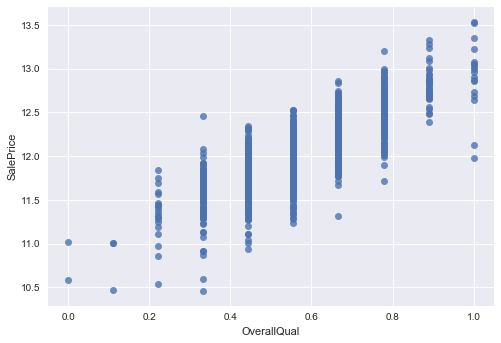

In [7]:
# 觀察重要特徵與目標的分布
# 第一名 : OverallQual              
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

sns.regplot(x=df['OverallQual'], y=train_Y, fit_reg=False)
plt.show()

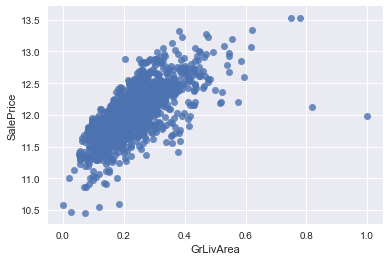

In [8]:
# 第二名 : GrLivArea
sns.regplot(x=df['GrLivArea'], y=train_Y, fit_reg=False)
plt.show()

In [9]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_char'] = (df['GrLivArea'] + df['OverallQual']) / 2
df['Multi_char'] = df['GrLivArea'] * df['OverallQual']
df['GO_div1p'] = df['GrLivArea'] / (df['OverallQual']+1) * 2
df['OG_div1p'] = df['OverallQual'] / (df['GrLivArea']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8605762627132263

# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[12]~[14], Out[12]~[14]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[18], Out[18]) 

In [10]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = '../data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values)) #將DataFrame 轉為 Numpy型式
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1)) #轉成Numpy後 shape為(n,) MinMaxScaler需要(n,1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [12]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y) #df.values 由DataFrame 轉為 Numpy型式
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.239014
Ticket      0.154172
Name        0.152239
Fare        0.123632
Age         0.100185
Cabin       0.088878
Pclass      0.065809
Embarked    0.027441
Parch       0.026161
SibSp       0.022467
dtype: float64

### 仿照參考資料 [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance?utm_medium=email&utm_source=mailchimp&utm_campaign=ml4insights) 作法
- 每次分別洗牌一個特徵類別(將該類別的值上下隨意調換), 藉由分數變化驗證特徵的重要性
- 但是變動性大, 類別每次的分數不固定
- 目前conda 的 eli5為0.8.1 不支援 Scikit-Learn 0.21+版本 可以選擇降版或使用 pip安裝 eli5 0.8.2版 可支援 0.21 Sklearn

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

train_num = len(train_Y)
valid_num = 20

mask = np.random.choice(train_num, valid_num, replace=False) #隨機從891個Train_set 選取 20個當作Valid_set 不重複
valid_X = df.iloc[mask]
valid_Y = train_Y[mask]

my_model = RandomForestClassifier().fit(df.values, train_Y) #以Train_set訓練的隨機森林model
perm = PermutationImportance(my_model, random_state=1).fit(valid_X, valid_Y) #將model拿來驗證洗牌類別
eli5.show_weights(perm, feature_names = df.columns.tolist())

Weight,Feature
0.1000 ± 0.1265,Ticket
0.0900 ± 0.1166,Sex
0.0900 ± 0.1166,Name
0.0900 ± 0.1166,Pclass
0.0600 ± 0.0748,Fare
0.0200 ± 0.0490,Age
0 ± 0.0000,Embarked
0 ± 0.0000,Cabin
0 ± 0.0000,Parch
0 ± 0.0000,SibSp


## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?


**Your answer:** *刪除一半重要性低的特徵後, 正確率下降 0.818 -> 0.809*


**Official answer:** *雖然範例與作業當中, 看似高重要性特徵的預估正確率較高較低有所不同, 但沒有差距太大
而且是只使用一半特徵的結果, 表示高重要特徵的資訊密度是高的, 使用較少特徵, 泛化能力(對外部資料預測力)也會提升,
因此只要不要刪到一半那麼多, 仍可能是適當的特徵選擇方式*

In [14]:
# 高重要性特徵 + 隨機森林
"""
Your Code Here
"""
high_feature = list(feats[:len(feats)//2].index) #取前一半特徵的index(項目名稱)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8092250230247888

In [15]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8182012329300049

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?


**Your answer:** *特徵組合生成新特徵, 對於原特徵幫助有限 0.818 -> 0.817, 但較高重要度特徵的效果好(0.809)*


**Official answer:** *範例中我們可以看出, 加.乘.除三個特徵加上去後, 有稍微好一點點
而作業中只挑選加與乘, 是否提升也有隨機性(可能更好或更差, 建議同學多執行幾次觀察)
這些特徵的組合, 未必有一定的方式, 解答只是舉例, 請同學自行決定要採用的方式
也許同學能自行開發出更有意義的特徵
另外若能參考領域知識, 還可能做出更有用的特徵組合*

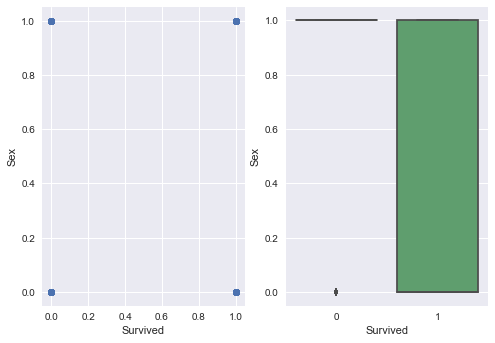

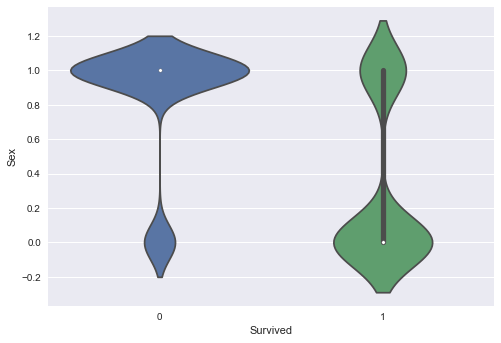

In [16]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

plt.subplot(1,2,1)
sns.regplot(x=train_Y, y=df['Sex'], fit_reg=False)
plt.subplot(1,2,2)
sns.boxplot(x=train_Y, y=df['Sex'])
plt.figure()
sns.violinplot(x=train_Y, y=df['Sex'])
plt.show()

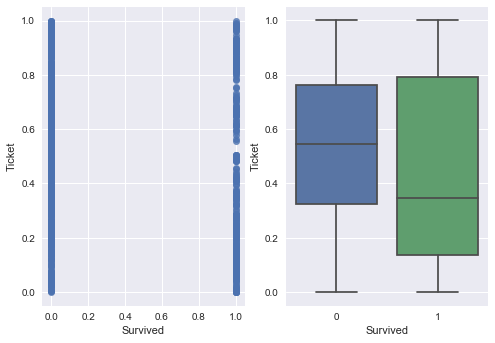

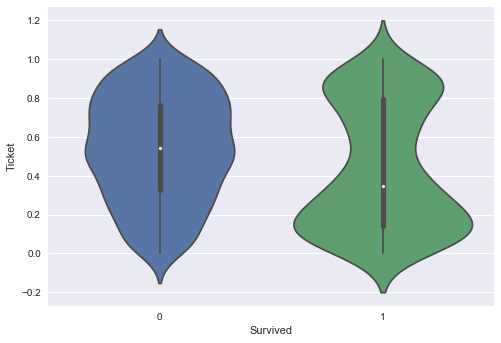

In [17]:
# 第二名       
plt.subplot(1,2,1)
sns.regplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.subplot(1,2,2)
sns.boxplot(x=train_Y, y=df['Ticket'])
plt.figure()
sns.violinplot(x=train_Y, y=df['Ticket'])
plt.show()

In [18]:
# 製作新特徵看效果
"""
Your Code Here
"""
df['Add_char'] = (df['Sex'] + df['Ticket'])/2
df['Multi_char'] = df['Sex'] * df['Ticket']
df['ST_div1p'] = df['Sex'] / (df['Ticket']+1) *2
df['TS_div1p'] = df['Ticket'] / (df['Sex']+1) *2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8171344856898767